In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, auc, roc_curve
from sklearn.preprocessing import MinMaxScaler

DATA_ROOT = "./data/ml100marathon-02-01/"

In [2]:
dfoff = pd.read_csv(os.path.join(DATA_ROOT,'train_offline.csv'))
dftest = pd.read_csv(os.path.join(DATA_ROOT,'test_offline.csv'))
dftest = dftest[~dftest.Coupon_id.isna()]
dftest.reset_index(drop=True, inplace=True)
print(dfoff.shape)
print(dftest.shape)
dfoff.head(20)

(1160742, 7)
(306313, 6)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


## 定義目標標籤

In [3]:
## Creat target label 
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label(row):
    if np.isnan(row['Date_received']):
        return -1
    if not np.isnan(row['Date']):
        td = pd.to_datetime(row['Date'], format='%Y%m%d') -  pd.to_datetime(row['Date_received'], format='%Y%m%d')
        if td <= pd.Timedelta(15, 'D'):
            return 1
    return 0

dfoff["label"] = dfoff.apply(label, axis=1)
dfoff["label"].value_counts()

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

## 增加 features

In [29]:
import seaborn as sns

In [24]:
# Generate features - weekday acquired coupon
def getWeekday(row):
    if (np.isnan(row)) or (row==-1):
        return row
    else:
        return pd.to_datetime(row, format = "%Y%m%d").dayofweek+1 # add one to make it from 0~6 -> 1~7

dfoff['weekday'] = dfoff['Date_received'].apply(getWeekday)
dftest['weekday'] = dftest['Date_received'].apply(getWeekday)

# weekday_type (weekend = 1)
dfoff['weekday_type'] = dfoff['weekday'].astype('str').apply(lambda x : 1 if x in ['6.0','7.0'] else 0 ) # apply to trainset
dftest['weekday_type'] = dftest['weekday'].astype('str').apply(lambda x : 1 if x in ['6.0','7.0'] else 0 ) # apply to testset

In [18]:
dfoff["weekday"].value_counts()

7.0    151239
5.0    125726
1.0    119318
6.0    108135
4.0     91726
3.0     76305
2.0     74520
Name: weekday, dtype: int64

In [25]:
dfoff["weekday_type"].value_counts()

0    901368
1    259374
Name: weekday_type, dtype: int64

In [26]:
weekdaycols = ['weekday_' + str(i) for i in range(1,8)]
print(weekdaycols)

tmpdf = pd.get_dummies(dfoff['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dfoff[weekdaycols] = tmpdf

tmpdf = pd.get_dummies(dftest['weekday'].replace(-1, np.nan))
tmpdf.columns = weekdaycols
dftest[weekdaycols] = tmpdf

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [27]:
# Generate features - coupon discount and distance
def getDiscountType(row):
    if row == 'null':
        return 'null'
    elif ':' in row:
        return 1
    else:
        return 0

def convertRate(row):
    """Convert discount to rate"""
    if row == 'null':
        return 1.0
    elif ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

def getDiscountMan(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountJian(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def processData(df):
    
    # convert discunt_rate
    df['discount_rate'] = df['Discount_rate'].astype('str').apply(convertRate)
    df['discount_man'] = df['Discount_rate'].astype('str').apply(getDiscountMan)
    df['discount_jian'] = df['Discount_rate'].astype('str').apply(getDiscountJian)
    df['discount_type'] = df['Discount_rate'].astype('str').apply(getDiscountType)
    
    # convert distance
    df.loc[df.Distance.isna(), "Distance"] = 99
    return df

dfoff = processData(dfoff)
dftest = processData(dftest)

0.0     501931
10.0    166877
1.0     143551
2.0      82186
99.0     69826
3.0      54214
4.0      39495
5.0      30317
6.0      23976
7.0      19029
8.0      15982
9.0      13358
Name: Distance, dtype: int64


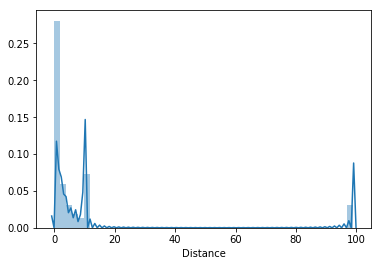

In [31]:
print( dfoff["Distance"].value_counts() )

sns.distplot( dfoff["Distance"] )

## 選定 feature

In [32]:
predictors = ['discount_rate',
            'discount_type',
            'discount_man', 
            'discount_jian',
            'Distance', 
            'weekday', 
            'weekday_type'] + weekdaycols
print(len(predictors), predictors)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


## 切 train/valid 資料

In [34]:
## Naive model
def split_train_valid(row, date_cut="20160416"):
    is_train = True if pd.to_datetime(row, format="%Y%m%d") < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train
    
df = dfoff[dfoff['label'] != -1].copy()
df["is_train"] = df["Date_received"].apply(split_train_valid)

train = df[df["is_train"]]
valid = df[~df["is_train"]]

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


## 準備好輸出預測結果檔案的工具

In [95]:
def exportSubmit(model, filename):

    targetset = dftest.copy()
    print(targetset.shape)

    targetset = targetset[~targetset.Coupon_id.isna()]
    targetset.reset_index(drop=True, inplace=True)
    testset = targetset[predictors].copy()

    y_test_pred = model.predict_proba(testset[predictors])
    test1 = testset.copy()
    test1['pred_prob'] = y_test_pred[:, 1]
    print(test1.shape)
    
    output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
    print(output.shape)

    output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
    output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
    output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
    output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
    output.reset_index(drop=True, inplace=True)
    
    ### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
    out = output.groupby("uid", as_index=False).mean()
    out = out[["uid", "pred_prob"]]
    out.columns = ["uid", "label"]
    out.to_csv(filename, header=["uid", "label"], index=False) # submission format
    out.head()

In [107]:
def exportSubmit_blending(models, percentages, filename):

    targetset = dftest.copy()
    print(targetset.shape)

    targetset = targetset[~targetset.Coupon_id.isna()]
    targetset.reset_index(drop=True, inplace=True)
    testset = targetset[predictors].copy()

    pred = 0
    for i in range(0, len(models)-1):
        y_test_pred = models[i].predict_proba(testset[predictors])
        pred = pred + y_test_pred * percentages[i]
        
    test1 = testset.copy()
    test1['pred_prob'] = pred[:, 1]
    print(test1.shape)
    
    output = pd.concat((targetset[["User_id", "Coupon_id", "Date_received"]], test1["pred_prob"]), axis=1)
    print(output.shape)

    output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
    output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
    output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:str(int(x)))
    output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
    output.reset_index(drop=True, inplace=True)
    
    ### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
    out = output.groupby("uid", as_index=False).mean()
    out = out[["uid", "pred_prob"]]
    out.columns = ["uid", "label"]
    out.to_csv(filename, header=["uid", "label"], index=False) # submission format
    out.head()

## 建模 與 預測

In [37]:
from sklearn.metrics import roc_auc_score, accuracy_score

### 模型 SGDClassifier

In [57]:
def check_model(data, predictors):
    
    classifier = lambda: SGDClassifier(
        loss='log', 
        penalty='elasticnet', 
        fit_intercept=True, 
        max_iter=100, 
        shuffle=True, 
        n_jobs=1,
        class_weight=None)

    model = Pipeline(steps=[
        ('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold(n_splits=3, shuffle=True)
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(data[predictors], 
                                  data['label'])
    
    return grid_search

model_sgd = check_model(train, predictors)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   23.6s finished


In [89]:
pred = model_sgd.predict_proba(valid[predictors])

auc_score = roc_auc_score(y_true=valid.label
                          , y_score=pred[:,1])

acc = accuracy_score(y_true=valid.label
                     , y_pred=pred.argmax(axis=1))

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

pred_sgd = pred

Validation AUC: 0.741, Accuracy: 0.952


In [96]:
exportSubmit(model_sgd, "Day_051_HW3_sgd.csv")

(306313, 19)
(306313, 15)
(306313, 4)


### 模型 GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 建立模型
model_gdbt = GradientBoostingClassifier(tol=100, subsample=0.75, n_estimators=250, max_features=len(predictors),
                                  max_depth=6, learning_rate=0.03)

# 訓練模型
model_gdbt.fit(train[predictors], train['label'])

# 預測測試集
pred = model_gdbt.predict_proba(valid[predictors])

# 評分
auc_score = roc_auc_score(y_true=valid.label
                          , y_score=pred[:,1])

acc = accuracy_score(y_true=valid.label
                     , y_pred=pred.argmax(axis=1))

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

pred_gdbt = pred

In [113]:
exportSubmit(model_gdbt, "Day_051_HW_gdbt.csv")

(306313, 19)
(306313, 15)
(306313, 4)


### 模型 RandomForestClassifier

In [102]:
from sklearn.ensemble import RandomForestClassifier

# 建立模型 (使用 20 顆樹，每棵樹的最大深度為 4)
model_rfc = RandomForestClassifier(n_estimators=20, max_depth=4)

# 訓練模型
model_rfc.fit(train[predictors], train['label'])

# 預測測試集
pred = model_rfc.predict(valid[predictors])

# 評分
auc_score = roc_auc_score(y_true=valid.label
                          , y_score=pred)

acc = accuracy_score(y_true=valid.label
                     , y_pred=pred)

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

pred_rfc = pred

Validation AUC: 0.500, Accuracy: 0.952


In [97]:
exportSubmit(model_rfc, "Day_051_HW3_rfc1.csv")

(306313, 19)
(306313, 15)
(306313, 4)


### 模型 RandomForestClassifier，僅取部分 feature

In [116]:
# 比較重要的 feature
print(len(predictors), predictors)

print("Feature importance: ", len(model_rfc.feature_importances_), model_rfc.feature_importances_)

14 ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']
Feature importance:  14 [8.85279817e-02 1.27188648e-02 2.99332113e-01 1.95646958e-01
 3.77690181e-01 1.16544557e-02 1.58989067e-03 2.62033983e-03
 7.98337401e-04 2.33599036e-03 1.67149636e-04 6.66457936e-04
 4.04779307e-04 5.84650032e-03]


In [118]:
predictors2 = ['discount_rate', 'discount_man', 'discount_jian', 'Distance']

# 建立模型 (使用 20 顆樹，每棵樹的最大深度為 4)
model_rfc2 = RandomForestClassifier(n_estimators=20, max_depth=4)

# 訓練模型
model_rfc2.fit(train[predictors2], train['label'])

# 預測測試集
pred = model_rfc2.predict(valid[predictors2])

# 評分
auc_score = roc_auc_score(y_true=valid.label
                          , y_score=pred)

acc = accuracy_score(y_true=valid.label
                     , y_pred=pred)

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

pred_rfc2 = pred

Validation AUC: 0.500, Accuracy: 0.952


In [120]:
predictors_old = predictors
predictors = predictors2

exportSubmit(model_rfc2, "Day_051_HW3_rfc2.csv")

predictors = predictors_old

(306313, 19)
(306313, 5)
(306313, 4)


### 模型 xgboost

https://www.kaggle.com/cbrogan/xgboost-example-python

In [105]:
import xgboost as xgb

# 建立模型
model_xgb = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

# 訓練模型
model_xgb.fit(train[predictors], train['label'])

# 預測測試集
pred = model_xgb.predict(valid[predictors])

# 評分
auc_score = roc_auc_score(y_true=valid.label
                          , y_score=pred)

acc = accuracy_score(y_true=valid.label
                     , y_pred=pred)

print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

pred_xgb = pred

Validation AUC: 0.500, Accuracy: 0.952


In [106]:
exportSubmit(model_xgb, "Day_051_HW3_xgb.csv")

(306313, 19)
(306313, 15)
(306313, 4)


### 加權融合 0.65 * RandomForestClassifier + 0.35 * xgboost

In [108]:
exportSubmit_blending([model_rfc, model_xgb], [0.65, 0.35], "Day_051_HW3_blending.csv")

(306313, 19)
(306313, 15)
(306313, 4)


### 加權融合 0.65 * GradientBoostingClassifier + 0.35 * xgboost

In [114]:
exportSubmit_blending([model_gdbt, model_xgb], [0.65, 0.35], "Day_051_HW3_blending2.csv")

(306313, 19)
(306313, 15)
(306313, 4)
